## Importing libraries and modules

In [1]:
import pandas as pd
import numpy as np
import pygmo as pg
import random
import functools
import math as m
import copy
from numpy import genfromtxt

# Geometry modules
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches 
import seaborn as sns

# Misc
import time 
from time import process_time
from scipy.spatial import distance_matrix
from scipy.spatial import ConvexHull
import secrets

# skopt
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV, space, plots
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt import gp_minimize

# sklearn modules
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, recall_score
from sklearn.metrics import make_scorer, precision_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 

# For ignoring warnings about bad classifiers - it's the nature of the algorithm to come across these
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Matplotlib configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 80
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## X and y must be declared as numpy matrices

### Loading in data set - churn

In [2]:
# X_df = pd.read_csv(r'X_train_churn.csv')
# X_train = X_df.values
# y_train = np.ravel(pd.read_csv(r'y_train_churn.csv'))

# X_test = pd.read_csv(r'X_test_churn.csv').values
# y_test = np.ravel(pd.read_csv(r'y_test_churn.csv'))

# X = np.vstack((X_train,X_test))
# y = np.append(y_train,y_test)

In [3]:
# Random subsets for running faster
# rand_index = random.sample(range(X_train.shape[0]),1600)
# X_train = X[rand_index,:]
# y_train = y[rand_index]

# rand_index = random.sample(range(X_test.shape[0]),400)
# X_test = X[rand_index,:]
# y_test = y[rand_index]

### Loading in data set - other

In [4]:
data_set = 'sonar'

In [5]:
X_df = pd.read_csv(f'UCI/{data_set}/X_train.csv')

X_train = pd.read_csv(f'UCI/{data_set}/X_train.csv').values
X_test = pd.read_csv(f'UCI/{data_set}/X_test.csv').values
y_train = genfromtxt(f'UCI/{data_set}/y_train.csv', delimiter=',').astype(int)
y_test = genfromtxt(f'UCI/{data_set}/y_test.csv', delimiter=',').astype(int)

In [6]:
# Number of features in model
total_features = int(X_train.shape[1])

# Feature names
feat_names = np.asarray(list(X_df.columns))

### Feature Subsets Partitioning - From 11 Feature Selection Methods

In [7]:
# Defining the best features, as chosen by a variety of filter and wrapper methods
# best_features = np.asarray([ 1,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 37, 39, 40, 43, 45, 46])
best_features = genfromtxt(f'UCI/{data_set}/best.csv', delimiter=',').astype(int)

# Defining features that are not as good as the best, but still good
# good_features = np.asarray([ 2,  6, 12, 15, 17, 18, 19, 21, 26, 27, 28, 30, 31, 32, 33, 35, 36])
good_features = genfromtxt(f'UCI/{data_set}/good.csv', delimiter=',').astype(int)

# Defining features that are not as good as the best, but still good
# worst_features = np.asarray([ 0, 16, 20, 22, 23, 24, 25, 29, 34, 38, 41, 42, 44, 47, 48, 49, 50])
worst_features = genfromtxt(f'UCI/{data_set}/worst.csv', delimiter=',').astype(int)

# Make all combinations of unions
bg_features = list(set(list(best_features)).union(set(list(good_features))))

bw_features = list(set(list(best_features)).union(set(list(worst_features))))

gw_features = list(set(list(good_features)).union(set(list(worst_features))))

all_features = np.asarray(list(range(total_features)))

print(f"There are {len(best_features)} best features, {len(good_features)} good features and {len(worst_features)} worst features")

There are 20 best features, 20 good features and 20 worst features


### Learning algorithms

In [8]:
# Set of learning algorithms
model_dict = {
    "SVC lin": SVC(random_state=42,kernel='linear',max_iter=int(1e4), probability=True),
    "Log lasso CV": LogisticRegressionCV(random_state=42,penalty='l1', solver = 'liblinear', cv=5, max_iter=1000),
#     "Log lasso": LogisticRegression(random_state=42,penalty='l1', solver = 'liblinear'),
    "Log lasso": LogisticRegression(solver='liblinear'),
    "Log ridge": LogisticRegression(random_state=42,penalty='l2'),
    "Gauss NB": GaussianNB(), # Naive Bayes
    "Dec trees": DecisionTreeClassifier(random_state=42),
    "Grad boost": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    "SVC rbf": SVC(random_state=42,kernel='rbf', max_iter=int(1e4)),
    "Random forest": RandomForestClassifier(random_state=42)
}

In [9]:
def get_model_time(model_string):
    
    '''
    Returns the seconds of how long a classifier takes to fit the whole data matrix
    '''
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_string])
    ])
    
    times = []
    
    # Times are inconsistent - get max by looping through several times
    for _ in range(100):
    
        start = process_time()
        pipeline.fit(X_train, y_train)
        end = process_time()
        
        times.append(end-start)
    
    return np.mean(times)

In [10]:
# Loading in the relevant results to compare against from the HFMOEA paper
hfmoea_results = {
    "breastcancer": np.asarray([[4,0.93],[5,0.982],[11,0.994]]),
    "congress": np.asarray([3,1]),
    "heart": np.asarray([[3,0.65],[4,0.925],[6,0.945]]),
    "ionosphere": np.asarray([[2,0.98],[12,0.99]]),
    "sonar": np.asarray([17,1]),
    "tictactoe": np.asarray([[2,0.66],[4,0.84],[9,0.99]]),
}

In [11]:
# Tuples for graphing every dataset, order: xlims, ylims, tick spacing
hfmoea_graph_lims = {
    "breastcancer": (0,30,0.907,1,3),
    "congress": (0,16,0.94,1.06,2),
    "heart": (0,13,0.63,0.96,2),
    "ionosphere": (0,34,0.6,1.02,4),
    "sonar": (0,60,0.922,1.003,6),
    "tictactoe": (0,9,0.65,1.01,1),
}

# Initial Population

### Initialise fully random population of features

In [12]:
def initialise_rand_pop(pop_size):
    
    # Initialise empty array
    initial_pop = []
    
    for i in range(pop_size):
        
        # Generate a random individual, add it to array
        chrom = np.random.randint(0,2,total_features)

        initial_pop.append(chrom)
        
    return np.asarray(initial_pop).astype(int)

### Make a seeded initial population

In [13]:
def make_initial_pop(pop_size, truly_random=False):
    
    if truly_random:
        return initialise_rand_pop(pop_size)
    
    pop = []

    # Declare all valid feature sets to draw from
    feat_sets = [all_features, bg_features, bw_features, gw_features, best_features, good_features, worst_features]
    
    for _ in range(pop_size):
            
        # Make a chromosome of zeros
        chrom = np.zeros((total_features,)).astype(int)
        
        # Choose a feature set at random
        cat = np.random.randint(0,len(feat_sets))

        # Only features in the given feature set are randomized, rest of the indices remain as zero
        chrom[feat_sets[cat]] = np.random.randint(0,2,len(feat_sets[cat]))

        # Ensure you never get all zeros in chromosome
        while len(np.unique(chrom)) == 1:

            chrom[feat_sets[cat]] = np.random.randint(0,2,len(feat_sets[cat]))
            
        pop.append(chrom)
    
    return np.asarray(pop)

### Normalize costs

In [14]:
def normalise(value):
    '''
    I: an evaluation value
    O: its normalised value 
    '''

    # The worst possible scenario is using all features (max comp time) 
    nadir = comp_time_all_X
    # The best possible scenario is a negligible time
    ideal = 1e-8
                    
    return ((value - ideal) / (nadir - ideal))

# Hyperparameters, evaluation, non-dom rank, crowding

### Scoring

In [15]:
def MatthewsCorrelation(confmat):
    '''
    Calculates the Matthews Correlation coefficient based on confusion matrix elements.
    '''
    
    # Ignore NaN warnings
    np.seterr(divide='ignore', invalid='ignore')
    
    # Decompose confusion mattrix elements
    [[tn, fp],[fn, tp]] = confmat
    
    # Calculate Matthew's Correlation Coefficient
    mc_coef = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    
    # Catch NaNs, return them as zero
    if np.isnan(mc_coef):
        return 0
    
    return mc_coef

In [16]:
def get_scores(predictor, pipeline, feature_indices):
    
    # Anything below 0.6 ROC AUC is very bad
    y_pred = pipeline.predict_proba(X_test[:,feature_indices])[:, 1]
    AUC_score = roc_auc_score(y_test, y_pred)
    
    if AUC_score < 0.6:
        AUC_score = 0
              
    dictionary = {"Validation Accuracy": accuracy_score(y_test, predictor),
                  "Specificity": recall_score(y_test, predictor, pos_label =0),
                  "Recall": recall_score(y_test, predictor),
                  "Precision": precision_score(y_test, predictor, zero_division=0.0),
                  "F1 Score": f1_score(y_test, predictor, zero_division=0.0),
#                   "ROC AUC": roc_auc_score(y, pipeline.predict_proba(X[:,feature_indices])[:, 1])  }
                  "ROC AUC": AUC_score,
                  "Matt Corr": MatthewsCorrelation(confusion_matrix(y_true = y_test, y_pred=predictor)),
                  "Num Features": int(len(feature_indices)) }
    
    return dictionary

In [17]:
def get_scores_for_pop(chrom):
    
    return pop_scores_dict[chrom.tobytes()]

### Evaluate objective functions

In [18]:
def evaluation(pop):
    
    '''
    I: a population, ndarray with chromosomes in each row
    O: matrix with normalized objective values of time and classifier score, as well as the chromosome in the same row
    '''
    # Empty matrix for writing in fitness 
    # 3 columns for storing results
    fitness_values = np.zeros((pop.shape[0], 3 + total_features)) 
    
    # Pipeline which uses NSGA_model from model_dict declared earlier
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[NSGA_model])
    ])
    
    # Loop over each chromosome, write into empty fitness matrix
    for i, chromosome in enumerate(pop):
        
        while len(np.unique(chromosome)) == 1:
            pop[i] = initialise_rand_pop(1)
        
        # Get indices of all the ones in the chromosome
        feature_indices = np.where(chromosome == 1)[0].tolist()
 
        # Objective 1 - validation accuracy for given chromosome

        # Store the chromosome
        fitness_values[i,3:] = copy.deepcopy(chromosome)
        
        # Fit the classifier on training dataset and generate predictions for test dataset
        start = process_time()
        model = pipeline.fit(X_train[:,feature_indices],y_train)
        end = process_time()
        
        # Objective 2 - comp. time for given chromosome
#         fitness_values[i,1] = normalise(copy.deepcopy(float(end) - float(start)))

        # Objective 2 - number of features used
        fitness_values[i,1] = len(np.where(chromosome == 1)[0])
    
        # Put given score as objective one, store all scores in dict associated with chromosome
        y_pred = model.predict(X_test[:,feature_indices])
        scores = get_scores(y_pred, model, feature_indices)
        
        # Discourage low feature cardinalities as good solutions
#         if scores['Num Features'] < constraint_features:
#             fitness_values[i,1] += penalty
            
        # Discourage low scores as good solutions
        if scores[scoring_metric] < constraint_score:
            fitness_values[i,0] -= penalty
        
        if scoring_metric == 'Mixed':
            score = (scores['F1 Score'] + scores['Recall'] + scores['Matt Corr'])/3
            
        else:
            score = float(scores[scoring_metric])
        
        # Make some scores infeasible as Pareto solutions
        if scores['Recall'] == 0 or scores['Matt Corr'] < 0.2:
            fitness_values[i,1] = fitness_values[i,1] + 1
        
        else:
            fitness_values[i,0] = score
            
        # Store all scores for this given individual
        pop_scores_dict[chromosome.astype(int).tobytes()] = scores

        # objective 1 - but for minimization 
        fitness_values[i,2] = (1-fitness_values[i,0])
            
    return fitness_values

## Getting and plotting non-dominated objective values for a set of random feas. solutions 

In [19]:
def plot_initpop(data, show_or_save, lims=True):
    
    '''
    Input: output of evaluation function for a given population
    Output: visualise all individuals in objective space, labelled by their initialisation origin
    
    '''
        
    plt.scatter(data[:,1], data[:,0], c='chocolate', s=25 ,marker="x", label='All Seven Feature Subsets')

    if lims:
        plt.xlim(set_xlim[0],set_xlim[1])
        plt.ylim(set_ylim[0],set_ylim[1])
    
#     if scoring_metric == 'Mixed':
#         plt.xlabel('Avg. MC, Recall and F1 Scores')
        
#     else:
#         plt.xlabel(scoring_metric)   
        
#     plt.ylabel("Normalised Comp. Time")
    
    plt.xlabel("Number of Features")
    plt.ylabel("Classification Accuracy")
    
    plt.legend(loc='upper left')
    
    if show_or_save == 0:
        
        plt.savefig(f"init_pop.pdf", bbox_inches='tight', format="pdf", dpi=1200)
        plt.clf()
        
    if show_or_save == 1:

        plt.show()

## Getting every non-dominated front in a given population, and the crowding distances for these fronts - using pygmo

In [20]:
def get_all_fronts(data, pop):
    '''
    Input: output of evaluation function (N * 3) where N is population size
    Output: array of all non-dominated fronts in the population
            array of indices of the constituent individuals of these fronts
            in the population
            
            (!!!)
            both of these are ordered in DESCENDING order by VALIDATION
            ACCURACY
    
    ndf - array of the indices of non-dominated fronts
          indices refer to the position of the point in the chromosome
    dl - domination list
    dc - domination count
    ndr - non-domination rank
    '''
    
    # Initalise empty list of fronts 
    fronts = []
    indices_ordered = []
    
    # Get only minimization objective values (second and third column),
    # then run fast non-dominated sorting algorithm
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(data[:,[1,2]])
    
    for i,front_indices in enumerate(ndf):
        
        # Extract rows from evaluation function output, corr to indices 
        # of the non-dominated fronts 
        front = data[ndf[i]]
        
        reshaped_index = np.reshape(ndf[i],
                                   (front.shape[0],1))
        
        front = np.hstack((front,reshaped_index))
                          
        # Put rows in order for each front, best first by accuracy
        # This also orders the indices
        front = front[front[:, 0].argsort()[::-1]]
        
        # Store indices column as ints
        index = front[:,-1].astype(int)
        
        # Separate indices column from rest of data
        front = front[:,:-1]

        # Append to fronts and indices list
        fronts.append(front)
        indices_ordered.append(index)
    
    return fronts, indices_ordered

In [21]:
def get_crowding_distances(fronts):
    '''
    Input: fronts from get_all_fronts
    Output: array of arrays of crowding distances for each front in fronts input
            all np.inf instances (boundaries of a given front) are replaced with
            the maximum crowding in the whole array of arrays that isn't np.inf
    '''
    
    crowd_distances = []
    
    for i,front in enumerate(fronts):
        
        # Handle singleton fronts
        if len(front)==1:
            crowd_distances.append(np.asarray([np.inf]))
        
        # Get crowding distances for the two objectives we want:
        # validation accuracy and cost
        else:
            distances = pg.crowding_distance(fronts[i][:,:2])

            crowd_distances.append(distances)
        
    # This replaces all np.inf with the next highest element that is not np.inf
    # Flatten crowding 2D array
    crowding_flat = [item for sub_list in crowd_distances for item in sub_list]

    # Make a list with no np.inf values, take its maximum
    max_dist = max([el for el in crowding_flat if el != np.inf]) 

    # Replace all np.inf in original array with maximum element
    for i,front in enumerate(crowd_distances):
        crowd_distances[i] = np.where(front == np.inf, max_dist, front)
        
    return crowd_distances

## Visualising all fronts and their crowding distances

In [22]:
def plot_all_fronts(data,fronts,crowding_metrics):
    
    for i in range(len(fronts)):
        plt.plot(fronts[i][:,0],fronts[i][:,1])
        sns.scatterplot(x=fronts[i][:,0],
                            y=fronts[i][:,1],
                            size=crowding_metrics[i],legend=False)
    
    print(f"There are {len(fronts)} non-dom fronts in this population")

    plt.xlabel("Validation Accuracy")
    plt.ylabel("Cost")
    plt.title("All non-dominated fronts, smaller point size indicates more crowding")
    
    plt.show()

## Non-dominated comparison - functions for next generation of the population

In [23]:
def fronts_to_nondomination_rank(fronts_indices, pop_size):
    '''
    Input: second output of get_crowding_distances function
    Output: a dictionary that ranks all fronts, the elements of each front
    in the fronts array are assigned a numerical ranking
    
    E.g. all indices (which correspond to chromosomes in the population)
    get assigned a zero in the dictionary
    '''
    
    # Declare empty dictionary
    nondomination_rank_dict = {}
    
    # Loop through all fronts, associate a rank (simply the index of the given front 
    # in the array of all fronts)
    for i,front in enumerate(fronts_indices):
        for x in front:   
            nondomination_rank_dict[x] = i
            
    # Give an infinititely bad rank for indices that are not part of a front
    indices_flatten = [item for sub_list in fronts_indices for item in sub_list]
    
    not_in_fronts = list(set(list(range(pop_size))) - set(indices_flatten))

    for index in not_in_fronts:
        nondomination_rank_dict[index] = np.inf
    
    return nondomination_rank_dict

In [24]:
def crowding_dictionary(fronts_indices, crowding, pop_size):
    '''
    Input: second output of get_crowding_distances function
    Output: a dictionary that associates a crowding distance with 
           index of the population
    '''
    
    crowding_dict = {}
    
    for i,front in enumerate(fronts_indices):
        for j,x in enumerate(front):   
            crowding_dict[x] = crowding[i][j]
            
    # Give an infinitely low crowding cost for indices that are not part of a front
    indices_flatten = [item for sub_list in fronts_indices for item in sub_list]

    not_in_fronts = list(set(list(range(pop_size))) - set(indices_flatten))

    for index in not_in_fronts:
        crowding_dict[index] = -(np.inf)
            
    return crowding_dict
    

In [25]:
def nondominated_sort(fronts_indices, crowding_metrics, pop_size):
    '''
    Input: second output of get_all_fronts distances, output of get_crowding_distances
           pop-size param (int) entered when population initialized
           
    This function depends on and calls both the fronts_to_nondomination_rank and the
    crowding_dictionary functions
        
    Output: 
    '''
    
    # Make a list of all indices in the population
    # Each index refers to a population chromosome
    indices = list(range(pop_size))
    
    # Call the relevant functions to get the dictionaries for ranking
    
    nondomination_rank_dict = fronts_to_nondomination_rank(fronts_indices, pop_size)
    
    crowding_dict = crowding_dictionary(fronts_indices, crowding_metrics, pop_size)

    def nondominated_compare(a,b):
        
        '''
        returns 1 if a dominates b, or if they equal, but a is less crowded
        return -1 if b dominates a, or if they equal, but b is less crowded
        returns 0 if they are equal in every sense
        
        functools then sorts the array according to these rules, with the best soln at index 0
        '''
        
        # Smaller domination rank is better
        if nondomination_rank_dict[a] > nondomination_rank_dict[b]:  
            return -1
        elif nondomination_rank_dict[a] < nondomination_rank_dict[b]:
            return 1
        
        # Larger crowding metric is better
        else:
            if crowding_dict[a] < crowding_dict[b]:   # crowding metrics, larger better
                return -1
            elif crowding_dict[a] > crowding_dict[b]:
                return 1
            else:
                return 0
            
    # Map function over indices, decreasing order: the best is the first
    non_dominated_sorted_indices = sorted(indices,key = functools.cmp_to_key(nondominated_compare),reverse=True) 
    return np.asarray(non_dominated_sorted_indices)

In [26]:
def sort_by_crowding_only(fronts_indices, crowding_metrics):
    
    # Flatten both input arrays
    indices_flatten = [item for sub_list in fronts_indices for item in sub_list]
    metrics_flatten = [item for sub_list in crowding_metrics for item in sub_list]
    
    # Matrix of zeros for storing index of chromosome in pop in first column
    # its crowding metric in the second
    M = np.zeros((len(indices_flatten),2))
    
    # Write flattened arrays into columns of empty matrix
    M[:,0] = indices_flatten
    M[:,1] = metrics_flatten
    
    # Sort by descending crowding metrics, highest first
    sorted_by_crowding = M[M[:, 1].argsort()[::-1]]
    
    return sorted_by_crowding[:,0].astype(int)

## Operators

### Tournament selection from two lists: nondomination rank and crowding rank

In [27]:
def tournament_selection(num_parents,num_offspring):
    '''
    Input: two ints, number of parents and desired number of offspring
    Generate 2 random numbers, take the smaller (parent list is already sorted, 
    smaller index is better)
    Keep only the smaller one, append to a list
    '''
    reproducing_individual_indices = []
    for _ in range(num_offspring):
        
        # Take two random indices that correspond to the output array of nondominated_sort
        contestants = np.random.randint(0,num_parents,2)
        
        # Take the minimum of these indices, as the lower the index is the fitter the individual
        winner = np.min(contestants)
        
        # Append onto offspring array
        reproducing_individual_indices.append(winner)
            
    return reproducing_individual_indices

In [28]:
def tournament_lambda(lambda_param, num_offspring, sorted_nondom, sorted_crowding, pop):
        
    # Number of individuals that will be drawn from nondominated sort list
    num_ndsort = int(m.ceil(lambda_param*num_offspring))
    offspring_ndsort_indices = sorted_nondom[tournament_selection(len(sorted_nondom), num_ndsort)].tolist()
    
    offspring_ndsort = pop[offspring_ndsort_indices]
        
    # To avoid duplicates, delete elements from offspring_ndsort in crowding list
    for el,i in enumerate(offspring_ndsort):
        
        index_in_crowding = np.where(sorted_crowding == el)[0][0]
        
        sorted_crowding = np.delete(sorted_crowding,index_in_crowding)

    # Number of individuals that will be drawn from crowding list
    num_crowding = int(m.floor((1-lambda_param)*num_offspring))
    offspring_crowding = sorted_crowding[tournament_selection(len(sorted_crowding), num_crowding)].tolist()
    
    offspring_crowding = pop[offspring_crowding]
    
    offspring = np.vstack((offspring_ndsort,offspring_crowding))
    
    return offspring
    

### Crossover operator

In [29]:
def k_point_crossover(parent1, parent2, k):
    """
    Perform k-point crossover on two parent numpy arrays to produce two children.

    Parameters:
        parent1 (numpy.ndarray): First parent array.
        parent2 (numpy.ndarray): Second parent array.
        k (int): Number of crossover points.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Two children arrays produced by crossover.
    """

    # Generate k unique crossover points
    crossover_points = sorted(np.random.choice(len(parent1), k, replace=False))

    # Initialize child arrays
    child1 = np.zeros_like(parent1)
    child2 = np.zeros_like(parent2)

    # Perform k-point crossover
    start_idx = 0
    for point in crossover_points:
        end_idx = point + 1
        if (point + 1) % 2 == 0:
            child1[start_idx:end_idx] = parent1[start_idx:end_idx]
            child2[start_idx:end_idx] = parent2[start_idx:end_idx]
        else:
            child1[start_idx:end_idx] = parent2[start_idx:end_idx]
            child2[start_idx:end_idx] = parent1[start_idx:end_idx]
        start_idx = end_idx

    # Copy the remaining segment after the last crossover point
    child1[start_idx:] = parent1[start_idx:]
    child2[start_idx:] = parent2[start_idx:]

    return child1, child2


In [30]:
def crossover(crossover_param, cross_k_param, offspring):
    '''
    Input: a crossover parameter (float, range zero to one), output of tournament_selection,
    feature_cardinality (int), surviving_individuals (top half of the array from nondominated_sort)
    
    Output: ndarray of crossed over
    '''
    
    # Desired number of crossed over individuals, based on parameter
    num_crossed = int(m.ceil(crossover_param*len(offspring)))
        
    # Check if this number is even, there must be an even number of individuals for crossover
    if (num_crossed % 2) != 0:
        num_crossed-=1
        
    # Declare empty list for crossed individuals
    crossed_offspring = []
    
    # Choose num_crossed amount of random indices
    indices_for_crossover = random.sample(range(len(offspring)),num_crossed) 
    
    # Reshape this array to allow looping through it
    indices_for_crossover_ = np.reshape(indices_for_crossover,(int(num_crossed/2),2))
    
    # Main loop
    for index_pair in indices_for_crossover_:
        
        parent1, parent2 = offspring[index_pair[0]], offspring[index_pair[1]]
        
        # Define a random single cutting point
        cut = np.random.randint(1,total_features)
        
        # Generate integer for k point crossover
#         if cross_k_param == 1:
#             k=1
            
#         else:
#         k = np.random.randint(1,cross_k_param)
        
        # Crossover mechanism
        crossed_1, crossed_2 = k_point_crossover(parent1, parent2, cross_k_param)
        
        # Append crossed individuals to array
        crossed_offspring.append(crossed_1)
        crossed_offspring.append(crossed_2)
    
    # Rewrite the original individuals with crossed over individuals, rest are unchanged
    offspring[indices_for_crossover] = crossed_offspring
    
    return offspring

### Mutation operator

In [31]:
def mutation(offspring,num_mutation_sites):
    '''
    Input: output of crossed_offspring, desired number of mutation sites (int), 
           total_features (int)
    Output: ndarray of mutated offspring
    '''
    
    # Catch errors
    if total_features < int(num_mutation_sites):
        return print("Mutation site number cannot exceed length of array of individual")
    
    for i,ind in enumerate(offspring.copy()):
        
        # Get random mutation sites for this individual, based on num_mutation_sites param
        mutation_sites = random.sample(range(total_features),int(num_mutation_sites))
        
        # Flip the bits at these sites
        for j, index in enumerate(mutation_sites):
            
            if ind[index]==0:
                offspring[i][index]=1
            else:
                offspring[i][index]=0
    
    # Return the mutated offspring
    return offspring

## Neighbourhood search

In [32]:
def ns_operator(feature_set, localsearch_param, best_front_chrom):
    
    output = []
    
    for chrom in best_front_chrom:        
        
        # Make a localsearch_param amount of copies of each chromosome in best_front_chrom
        temp = np.tile(np.asarray(copy.deepcopy(chrom)),(localsearch_param,1))
        
        # Get UNIQUE random indices depending on the given feature_set
        rand_index = random.sample(list(feature_set),localsearch_param)
        
        # Flip bits at the unique random indices
        for i in range(localsearch_param):
        
            if temp[i][rand_index[i]]==0:
                temp[i][rand_index[i]]=1
            if temp[i][rand_index[i]]==1:
                temp[i][rand_index[i]]=0
                
            # If there are clones, try 150 times to fix this, prevent infinite loops
            counter = 0
            while np.array_equal(temp[i], chrom):
                
                rand_index_ = random.sample(list(feature_set),localsearch_param)
                
                if temp[i][rand_index_[i]]==0:
                    temp[i][rand_index_[i]]=1
                if temp[i][rand_index_[i]]==1:
                    temp[i][rand_index_[i]]=0
                    
                counter += 1
                
                if counter > 150:
                    break
                
            output.append(copy.deepcopy(temp[i]))
            
    return np.asarray(output)

In [33]:
def best_PF_sofar(fronts_all_iter, front_points, elitism):
    '''
    Returns the top front_points number of incumbent non-dominated members of the population
    Used for local search
    '''
    
    # Count how many points there are in the list of the best fronts from every iteration so far
    points_ = points_in_list(fronts_all_iter)
    
    # Stop errors from an initial population that has a best front with less than front_points points
    if points_ < front_points:
        front_points = points_
    
    # Create a matrix to write all these points into
    matrix = np.zeros((points_,total_features+3))
    
    c=0
    for front in fronts_all_iter:

        for point in front:

            matrix[c,:] = copy.deepcopy(point)

            c+=1
        
    # Run non-dom sorting on the whole matrix
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(matrix[:,[1,2]])
    
    # Flatten output list of non-dominated fronts 
    ndf_flat = np.asarray([item for sub_list in ndf for item in sub_list])
    
    if elitism:
    
        # Take a front_points amount of points from the top of this list, return their respective chromosomes
        best_n = matrix[ndf_flat[:front_points]]

        best_n_pops = []

        for el in best_n:

            best_n_pops.append(el[3:].astype(int))

        return np.asarray(best_n_pops)
    
    else: 
        # Choose chromosomes using tournament selection
        
        indices = tournament_selection(num_parents=len(ndf_flat),num_offspring=front_points)
        
        tourn_chosen = matrix[ndf_flat[indices]]

        pops = []

        for el in tourn_chosen:

            pops.append(el[3:].astype(int))

        return np.asarray(pops)

In [34]:
def points_in_list(fronts_all_iter):
    '''
    Returns how many individual points in are in all the Pareto Fronts in fronts_all_iter, allowing deconstruction
    '''
    
    count = 0
    
    for front in fronts_all_iter:
        
        count += front.shape[0]
        
    return count

In [35]:
def neighbourhood_search(fronts_all_iter, localsearch_param, front_points=6):

    '''
    I: output of get_all_fronts (fronts and fronts_indices),
    front_points: an integer, fxn takes a front_points amount of NON-EDGE points in the fronts.
    e.g. for a front_points value of 5:
         if there are 7 points in the first front, the 5 in the center are taken
         if there are 4 points in the first front, two center ones are taken and three points from
         the front behind it (fronts[1]) are then taken, for a total of five points
        
    localsearch_param: for each point in the front, this integer value controls how many UNIQUE 
    indices are flipped (1 to 0, or 0 to 1)
    
    pop: the current population (for this iteration and run), used to retrieve the chromosomes
    
    O: an array of chromosomes of new solutions within the neighbourhood of the best two fronts
    '''
        
#     # Random chance between elitism or exploration
#     if elitism_param == 0:
#         elitism = np.random.randint(0,2)
        
#     if elitism_param == 1:
#         elitism = 1
    
    # Use the indices to fetch the top (default six) chromosomes in the population by nd-rank
    best_front_chrom = best_PF_sofar(fronts_all_iter, front_points, elitism_param)
    
    # Make a list off all the different feature index subsets you have
    feature_subsets = [best_features, worst_features, good_features, best_features]
    
    neighbourhood = []
    
    # Perform a search using all different subsets
    for j,subset in enumerate(feature_subsets):
        
        neighbourhood.append(ns_operator(subset, localsearch_param, best_front_chrom))
        
    # Reshape into standard population output
    output = np.asarray([item for sub_list in neighbourhood for item in sub_list])
            
    return output

In [36]:
def get_neighbourhood(polygon_selection, localsearch_param, pop, fronts, fronts_indices):
    
    # If exploitative search isn't on, do neighbourhood search as normal
    if polygon_selection == 0:
        
        neighbourhood = neighbourhood_search(fronts_all_iter, localsearch_param)
        
        # Get at least 10 points from local search - due to random sampling can get small numbers or singletons
        # This is a cheap while loop - it is just array manipulations, no ML training takes place
        while len(neighbourhood) < 10:
            neighbourhood = neighbourhood_search(fronts_all_iter, localsearch_param)
            
        return neighbourhood
    
    # Use more expensive polygon selection for the last few iterations
    if polygon_selection == 1:
        
        neigh_before = neighbourhood_search(fronts_all_iter, localsearch_param=exploit_param, front_points=10)
        
        # Get objective values of the chromosomes from neighbourhood search
        neigh_before_ev = evaluation(neigh_before)

        # Accept only the solutions close to the front
        neigh_after_ev, neigh_after = points_inside_area(fronts, neigh_before_ev)
        
        # Must have more than one solution accepted for crossover and mutation
        if len(neigh_after) > 1:
        
            # Do crossover and mutation on exploitative local search solutions
            crossed_exploit = crossover(1, cross_k_param, copy.deepcopy(neigh_after)) 
            mutated_exploit = mutation(copy.deepcopy(crossed_exploit),4)

            # Preserve all these local search solutions in a separate list
            localsearch_accepted.append(neigh_after_ev)
            localsearch_accepted.append(evaluation(crossed_exploit))
            localsearch_accepted.append(evaluation(mutated_exploit))
        
        # Display the results of this polyselect search as a slice
        if save_slices == 1:
            
            display_polygons(fronts, neigh_before_ev, neigh_after_ev, polyselect_param, plot_polys=1, show_or_save=0)
        
        return neigh_before

## Area selection rules for local search

In [37]:
def make_polygons(front, polyselect_param):
    
    '''
    Makes a single polygon using any given front in the objective space as an input
    '''

    new_front = copy.deepcopy(front)

    # Making a new front, that's slightly offset from the original one
    new_front[:,0] = new_front[:,0] - polyselect_param
    new_front[:,1] = new_front[:,1] + polyselect_param*10

    polygon = [[1,0]]

    front_pointsnum = len(new_front)

    for i, el in enumerate(new_front):    

        # Special handling for first point
        if i == 0:
            polygon.append([1,el[1]])

        # Handling for non-edge points
        if i != front_pointsnum - 1:
            polygon.append(el)

        # Special handling for last point
        else:
            polygon.append(el)
            polygon.append([0,el[1]])
            polygon.append([0,0])

    # Convert the list to a shapely object    
    polygon_ = Polygon(tuple(polygon))

    # Make polygon as matplotlib graphical object
    poly_patch = patches.Polygon(polygon, linewidth=1, edgecolor='orange', facecolor=(0, 1, 0, 0.2),label='Acceptance Polygon')
    
    return polygon_, poly_patch

In [38]:
def points_inside_area(fronts, neigh_ev):
    '''
    Todo 
    '''
        
    # Handle singleton fronts, ensure there are no duplicate vertices for polygons
    if len(fronts[0]) > 1:
        front = fronts[0]
        
    # If the first front is too small, use the second one
    else:
        front = fronts[1]
        
    accepted = []
    accepted_pops = []
    
    # Only take the x and y of the front
    front = front[:,:2] 
    
    # Ensure there are no duplicates, sort by descending score
    front = np.unique([tuple(row) for row in front], axis=0)
    front = front[front[:, 0].argsort()[::-1]]
    
    # Separate the points and their respective populations
    neigh_points, neigh_pops = neigh_ev[:,:2], neigh_ev[:,3:].astype(int)
        
    # Get the polygon object 
    polygon, poly_patch = make_polygons(front, polyselect_param)
    
    # Check if a point from localsearch is inside the polygon. Only accept these
    for i, point in enumerate(neigh_points):
        
        if polygon.contains(Point(point)):
            accepted.append(neigh_ev[i])
            accepted_pops.append(neigh_ev[i][3:].astype(int))
        
    return np.asarray(accepted), np.asarray(accepted_pops)

## Functions for getting the best results, their scores, and visualising them

In [39]:
def get_names(member):
    '''
    For a given member of a front, get the names of its associated features
    '''
    
    ones_in_chrom = np.where(member[3:].astype(int) == 1)[0]
    
    names = feat_names[ones_in_chrom]
    
    acc = np.round(member[0],3)
    cost = np.round(member[1]*100,1)
    
    print(f"{scoring_metric}: {acc}, \n")
    print(f"% Of Comp. Runtime For All Features: {cost}% \n")
    print(f"Number of features used: {len(names)} out of {total_features}\n")
    print(f"Feature Subset: {names}")

In [40]:
def front_scores(front, sortby):
    
    columns = np.asarray(['Accuracy','Specificity', 'Recall', 'Precision', 'F1 Score', 'ROC AUC', 'Matt Corr', '|F|', 'Comp Time'])
    
    # Declare dataframe dimensions
    num_points = front.shape[0]
    data = np.zeros((num_points, columns.shape[0]))

    # Write the scores disctionary for a given chromosome into the dataframe
    for i in range(num_points):
        
        chrom = front[i,3:].astype(int)

        scores = get_scores_for_pop(chrom)

        data[i,:columns.shape[0]-1] = [(v) for k,v in scores.items()] 
                        
    # Add computational time to dataframe
    data[:,columns.shape[0]-1] = front[:,1]
        
    # Sort and round the dataframe by userprovided string
    data = data[data[:, np.where(columns == sortby)[0][0]].argsort()[::-1]]
    data = np.round(data,3)
    
    # Declare the dataframe 
    df = pd.DataFrame(columns = columns, data = data)
    
    # Ensure feature cardinality is given as an int
    df['|F|'] = df['|F|'].astype(int)
    
    return df

In [41]:
def best_PF(fronts_all_iter):
    '''
    Takes an array of the best fronts from each iteration, and returns the best front from these
    I.e. this function gives the non-dominated chromosomes for 
    '''
    
    # Flatten the array of the best fronts form all iterations
    fronts_flat = np.asarray([item for sub_list in fronts_all_iter for item in sub_list])
    
    # Define the number of columns the output matrix will have
    columns = fronts_flat[0].shape[0]
    
    # Stack all the solutions in the different fronts into a single matrix
    matrix = np.reshape(fronts_flat[0],(1,columns))

    for el in fronts_flat[1:]:

        reshaped_el = np.reshape(copy.deepcopy(el), (1,columns))

        matrix = np.vstack((matrix, reshaped_el))
        
    # Run non-dom sorting on the whole matrix
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(matrix[:,[1,2]])
        
    # Get the non-dominated solutions
    best = matrix[ndf[0]]
    
    # Sort by ascending
    best_sorted = best[best[:, 0].argsort()[::-1]]
    
    uniques = np.unique([tuple(row) for row in best_sorted], axis=0)
    
    uniques = uniques[uniques[:, 0].argsort()[::-1]]

    return uniques

In [42]:
def chrom_scores(chrom, sortby):
    
    member = chrom
    pop = initialise_rand_pop(2)
    
    pop[0] = chrom
    
    ev = evaluation(pop)
    
    columns = np.asarray(['Accuracy','Specificity', 'Recall', 'Precision', 'F1 Score', 'ROC AUC', 'Matt Corr', 'Comp Time'])
    
    data = np.zeros((1, columns.shape[0]))

    scores = get_scores_for_pop(chrom)

    data[0,:columns.shape[0]-1] = [(v) for k,v in scores.items()] 
                
    data[:,columns.shape[0]-1] = chrom[1]
    
    data = data[data[:, np.where(columns == sortby)[0][0]].argsort()[::-1]]

    data = np.round(data,3)

    results_df = pd.DataFrame(columns = columns, data = data)

    display(results_df)
    
    get_names(ev[0])

## Creating next generation, plotting each generation

In [43]:
def save_numpy_array_as_csv(array, file_path):
    try:
        np.savetxt(file_path, array, delimiter=',')
        print("Array successfully saved as CSV file.")
    except Exception as e:
        print("Error occurred while saving the array:", e)

In [44]:
def get_run_score(points1, points2):
    """
    Create a polygon from two sets of points representing two separate piecewise linear functions, or PFs
    This effectively measures the progress that a run of the algorithm 

    Parameters:
        points1 (numpy array): Points of the first piecewise linear function with shape (N, 2), where N is the number of points.
        points2 (numpy array): Points of the second piecewise linear function with shape (M, 2), where M is the number of points.

    Returns:
        area of polygon
    """
    
    # Shapely draws vertices in the order you supply point tuples
    # So you have to supply the points in a specific order
    points_in_order = []
    
    # Reverse points list2
    points2 = points2[points2[:, 0].argsort()]
    
    for point in points1:
        points_in_order.append(copy.deepcopy([point[1],point[0]]))
    
    for point in points2:
        points_in_order.append(copy.deepcopy([point[1],point[0]]))
    
    polygon = Polygon(tuple(points_in_order))

    return polygon.area


In [45]:
def NSGA2_create_next_generation(pop, config):
    '''
    For a given population, generate its offspring population, including application of all operators
    '''
    
    # Load in parameters for this iter
    lambda_param = config["lambda_param"]
    tournament_param = config["tournament_param"]
    crossover_param = config["crossover_param"]
    num_mutation_sites = config["num_mutation_sites"]
    localsearch_param =  config["localsearch_param"]
    cross_k_param = config["cross_k_param"]
    
    # Overwrite global var if any
    pop = pop
    
    # Get normalised obj values for population
    evaluated_pop = evaluation(pop)
        
    # Get fronts and the population index of each individual in each front
    fronts, fronts_indices = get_all_fronts(evaluated_pop, pop)
    crowding_metrics = get_crowding_distances(fronts)
    
    # Add the best front for this generation to a running list
    fronts_all_iter.append(fronts[0])
    
    # Sort every individual based on their domination rank and their crowding distance
    # The index of the fittest individual in this population is in index 0 
    sorted_nondom = nondominated_sort(fronts_indices, crowding_metrics, pop_size)
    
    # Sort by crowding metrics only
    sorted_crowding = sort_by_crowding_only(fronts_indices, crowding_metrics)
    
    # Define number of offspring left after tournament selection using the given parameters
    num_offspring = int(m.floor(tournament_param*pop.shape[0]))
    
    # Use tournament selection for choosing which surviving individuals get to crossover
    offspring = tournament_lambda(lambda_param, num_offspring, sorted_nondom, sorted_crowding, pop)

    # Do crossover on these offspring
    crossed_offspring = crossover(crossover_param, cross_k_param, offspring)

    # Do mutation on the crossed offspring
    next_generation = mutation(crossed_offspring, num_mutation_sites)
        
    # Depending on polygon search parameter boolean, do cheap local search or expensive selective polygon search
    neighbourhood = get_neighbourhood(polygon_selection, localsearch_param, pop, fronts, fronts_indices)
    
    # In the very unlikely event there is one or no accepted solutions, don't cross or mutate
    if neighbourhood.shape[0] > 1:
        
        next_generation = np.vstack((next_generation,copy.deepcopy(neighbourhood)))

        # Cross and mutate the accepted local search solutions
        crossed_local = crossover(1, cross_k_param, copy.deepcopy(neighbourhood)) 
        next_generation = np.vstack((next_generation,crossed_local))

        mutated_local = mutation(copy.deepcopy(crossed_local),num_mutation_sites)
        next_generation = np.vstack((next_generation,mutated_local))
         
        if polygon_selection == 0 and save_slices == 1:
            crossed_ev, mutated_ev = evaluation(crossed_local), evaluation(mutated_local)
            plot_neighbourhood(fronts, evaluation(neighbourhood), crossed_ev, mutated_ev, show_or_save=0)
            
    # Want to keep pop_size consistent, generate new pop for the remainder needed for this
    if next_generation.shape[0]<pop_size: 
        
        until_popsize = int(pop_size - len(next_generation))
        remainder = make_initial_pop(until_popsize)
        next_generation = np.vstack((next_generation,remainder))
            
    every_iter_pop.append(next_generation)
    
    return None

## Parameter Grid Search

In [46]:
# Operator parameters
array_lambdaparams = np.linspace(1, 0, 4)
array_tournparams = np.asarray([0.25,0.5, 0.75, 1])
array_crossover = np.asarray([1,2,3,4])
array_mutsites = np.asarray([1,2,3,4])
array_elitism = np.asarray([0,1])

op_list = [array_lambdaparams, array_tournparams, array_crossover, array_mutsites, array_elitism]

In [47]:
def create_random_grid_search_space(param_values, num_samples):
    """
    Create a random grid search space with a specified number of samples.

    Parameters:
        param_values (list of numpy arrays): List of numpy arrays, each containing the values for a parameter.
        num_samples (int): The number of random parameter sets to be sampled.

    Returns:
        numpy array: A 2D array where each row represents a combination of parameter values.
    """
    assert num_samples > 0, "Number of samples must be greater than 0."

    # Generate the meshgrid
    meshgrid = np.meshgrid(*param_values)

    # Flatten and stack the meshgrid
    # If you don't want a random subset of the search space, just return this
    search_space = np.column_stack([m.flatten() for m in meshgrid])
    
    print(f"Search space size: {search_space.shape[0]}")
    
    if search_space.shape[0] < num_samples:
        return search_space

    # Randomly sample num_samples parameter sets
    random_indices = np.random.choice(search_space.shape[0], num_samples, replace=False)
    random_search_space = search_space[random_indices]
    
    return random_search_space

In [48]:
search_space = create_random_grid_search_space(op_list, num_samples=50)
search_space.shape

Search space size: 512


(50, 5)

In [49]:
def config_params_change(config, grid, set_index):
    '''
    For a given run of the algorithm, sets the parameters to those in the search space
    '''
    
    config["lambda_param"] = grid[set_index][0]
    config["tournament_param"] = grid[set_index][1]
    config["cross_k_param"] = int(grid[set_index][2])
    config["num_mutation_sites"] = int(grid[set_index][3])
    config["elitism_param"] = int(grid[set_index][4])

## Setting Parameters

In [57]:
config = {
    "pop_size" : 100,                # the EVEN number of individuals in the population
    "total_features": int(X_train.shape[1]),  # the number of features in the data matrix
    "tournament_param": 0.33,        # % of pop_size you want as offspring after to tournament selection
    "lambda_param": 0.33,               # lambda of one promotes intensification, lambda of 0 diversification
    "crossover_param": 1,          # % of offspring you want to crossover
    "cross_k_param": 3,            # max number of cut points for k point crossover
    "num_mutation_sites": 3,         # MUST BE <= feature_cardinality
    "localsearch_param": 3,          # number of searches done locally per best six individuals each iteration
    "polyselect_last_n": 2,        # number of iters you want PS to kick in, e.g. one is just the last iter
    "num_iter": 10,                # number of iterations per run of the algorithm (how many generations per run)
    "save_slices": 0,              # turn on if you want to save a pdf of every single iteration
    "exploit_param": 4,
    "elitism_param": 0,
    
    # Hyper-parameters:
    "constraint_features": 0,
    "constraint_score": 0,
    "penalty": 0,
}

### Initialise Parameters 

In [51]:
# Set up global parameters, that stay the same regardless of iteration
# Some can be changed within the main NSGA-II loop, if testing for good parameter sets
pop_size = config["pop_size"]
num_iter = config["num_iter"]
total_features = config["total_features"]
cross_k_param = config["cross_k_param"]
polyselect_last_n = config["polyselect_last_n"]
exploit_param = config["exploit_param"]
elitism_param = config["elitism_param"]

# Parameters related to visualisation
save_slices = config["save_slices"]
# Set consistent axis limits for every plot
graph_axes = hfmoea_graph_lims[data_set]
set_xlim = (graph_axes[0],graph_axes[1])
set_ylim = (graph_axes[2],graph_axes[3])

# Hyperparams
constraint_features = config["constraint_features"]
constraint_score = config["constraint_score"]
penalty = config["penalty"]

### Global Parameters - Same Every Run

In [52]:
# Declare model from model_dict that you want to run NSGA-II for 
NSGA_model = 'Log lasso'

# Declare which scoring metric to use
scoring_metric = 'Validation Accuracy'

# Declare the scoring metric achieved if the chosen classifer is trained on all features and rows
score_all_X = 0.6

# Do 100 loops of the model then get its average to get the nadir for the normalisation
# comp_time_all_X = get_model_time(NSGA_model)
# print(comp_time_all_X)

### Initial population, its best front and saving its plot

In [53]:
# Declare empty dictionary for scoring chromosomes and their scores
pop_scores_dict = {}

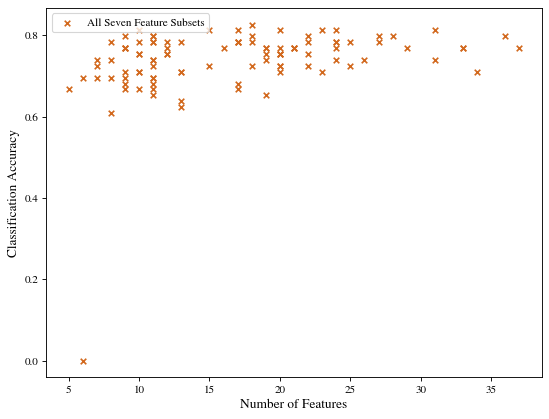

In [54]:
# # init_pop = genfromtxt('diverse_pop_ Recall_loglasso.csv', delimiter=',')
init_pop = make_initial_pop(pop_size)

# init_pop = diverse_pop

#  Get all fronts of initial population
init_pop_eval = evaluation(init_pop)
init_fronts, init_fronts_indices = get_all_fronts(init_pop_eval, init_pop)

# Save or show a save of initial pop, save is zero, show is one
plot_initpop(init_pop_eval, show_or_save=1, lims=False)

## Main loop

In [55]:
def plot_PF(front, figure_title, show_or_save, lims=True):
    '''
    Plots all fronts, from every iteration
    '''
    # Plot best front from initial pop for comparison purposes
    plt.scatter(init_fronts[0][:,1], init_fronts[0][:,0], color = 'cornflowerblue', s=45, marker="X", label="Init pop PF")
    plt.scatter(front[:,1], front[:,0], color = 'firebrick', s=45, marker="X", label=f"FNSGA-II {num_iter} Iter PF")
    plt.plot(front[:,1], front[:,0], color = 'firebrick')

#     plt.scatter(vanilla[:,0], vanilla[:,1], color = 'cornflowerblue', s=45, marker="X", label=f"NSGA-II {num_iter} Iter PF")
    
    paper_results = hfmoea_results[data_set]
    
    if data_set == 'congress' or data_set == 'sonar':
        plt.scatter(paper_results[0], paper_results[1], color = 'navy', s=45, marker="s")
        
    else:
        plt.plot(paper_results[:,0], paper_results[:,1], color = 'navy', label=f"HFMOEA Paper", linestyle='--')
        plt.scatter(paper_results[:,0], paper_results[:,1], color = 'navy', s=45, marker="s")
    
#     plt.vlines(x = score_all_X, ymin = 0, ymax = 1, color = 'purple', label=f"{scoring_metric} Full X", linestyle='--', linewidth=0.5)

#     if scoring_metric == 'Mixed':
#         plt.xlabel('Avg. MC, Recall and F1 Scores')
        
#     else:
#         plt.xlabel(scoring_metric)
    
#     plt.ylabel("Normalised Comp. Time")

    plt.xticks(np.arange(graph_axes[0], graph_axes[1], step=graph_axes[4]))

    plt.ylabel("Classification Accuracy")
    plt.xlabel("No. of Features Selected")

    plt.legend(loc='lower right')
    
    if lims:
        plt.xlim(set_xlim[0],set_xlim[1])
        plt.ylim(set_ylim[0],set_ylim[1])
    
    if show_or_save == 0:

        plt.savefig(f"Graphs/{figure_title}.pdf", format="pdf", dpi=1200, bbox_inches='tight')

        plt.clf()
    
    if show_or_save == 1:
        plt.show()

Population 0, Param Set 0
Set at current iter is (0.33333333333333337, 0.25, 3, 4, 1) in format (lam,tourn,cross,mut,elit)
Population 0, Param Set 1
Set at current iter is (0.33333333333333337, 0.75, 3, 4, 0) in format (lam,tourn,cross,mut,elit)
Population 0, Param Set 2
Set at current iter is (1.0, 1.0, 4, 4, 0) in format (lam,tourn,cross,mut,elit)
Population 0, Param Set 3
Set at current iter is (0.33333333333333337, 0.75, 1, 2, 1) in format (lam,tourn,cross,mut,elit)
Population 0, Param Set 4
Set at current iter is (1.0, 1.0, 1, 4, 0) in format (lam,tourn,cross,mut,elit)
Population 0, Param Set 5
Set at current iter is (1.0, 0.5, 3, 3, 1) in format (lam,tourn,cross,mut,elit)
Population 0, Param Set 6
Set at current iter is (0.6666666666666667, 1.0, 3, 2, 1) in format (lam,tourn,cross,mut,elit)
Population 0, Param Set 7
Set at current iter is (0.0, 0.5, 3, 1, 1) in format (lam,tourn,cross,mut,elit)
Population 0, Param Set 8
Set at current iter is (0.6666666666666667, 0.25, 1, 4, 1) i

Population 1, Param Set 21
Set at current iter is (0.33333333333333337, 1.0, 3, 4, 0) in format (lam,tourn,cross,mut,elit)
Population 1, Param Set 22
Set at current iter is (0.33333333333333337, 0.25, 3, 3, 0) in format (lam,tourn,cross,mut,elit)
Population 1, Param Set 23
Set at current iter is (0.33333333333333337, 0.25, 1, 1, 0) in format (lam,tourn,cross,mut,elit)
Population 1, Param Set 24
Set at current iter is (0.33333333333333337, 0.5, 2, 3, 0) in format (lam,tourn,cross,mut,elit)
Population 1, Param Set 25
Set at current iter is (0.0, 0.5, 3, 4, 0) in format (lam,tourn,cross,mut,elit)
Population 1, Param Set 26
Set at current iter is (0.6666666666666667, 0.75, 4, 3, 1) in format (lam,tourn,cross,mut,elit)
Population 1, Param Set 27
Set at current iter is (1.0, 1.0, 2, 2, 1) in format (lam,tourn,cross,mut,elit)
Population 1, Param Set 28
Set at current iter is (0.0, 0.5, 4, 2, 1) in format (lam,tourn,cross,mut,elit)
Population 1, Param Set 29
Set at current iter is (0.0, 0.5, 4

Population 2, Param Set 42
Set at current iter is (0.6666666666666667, 0.75, 1, 1, 0) in format (lam,tourn,cross,mut,elit)
Population 2, Param Set 43
Set at current iter is (0.33333333333333337, 0.5, 1, 4, 1) in format (lam,tourn,cross,mut,elit)
Population 2, Param Set 44
Set at current iter is (0.6666666666666667, 0.75, 4, 1, 0) in format (lam,tourn,cross,mut,elit)
Population 2, Param Set 45
Set at current iter is (1.0, 0.5, 3, 1, 0) in format (lam,tourn,cross,mut,elit)
Population 2, Param Set 46
Set at current iter is (1.0, 0.75, 1, 1, 1) in format (lam,tourn,cross,mut,elit)
Population 2, Param Set 47
Set at current iter is (0.0, 1.0, 1, 4, 0) in format (lam,tourn,cross,mut,elit)
Population 2, Param Set 48
Set at current iter is (1.0, 0.25, 4, 3, 1) in format (lam,tourn,cross,mut,elit)
Population 2, Param Set 49
Set at current iter is (0.6666666666666667, 1.0, 1, 3, 1) in format (lam,tourn,cross,mut,elit)
Population 3, Param Set 0
Set at current iter is (0.33333333333333337, 0.25, 3,

Population 4, Param Set 13
Set at current iter is (0.6666666666666667, 0.5, 2, 4, 0) in format (lam,tourn,cross,mut,elit)
Population 4, Param Set 14
Set at current iter is (0.33333333333333337, 1.0, 1, 1, 1) in format (lam,tourn,cross,mut,elit)
Population 4, Param Set 15
Set at current iter is (0.0, 1.0, 1, 2, 1) in format (lam,tourn,cross,mut,elit)
Population 4, Param Set 16
Set at current iter is (1.0, 1.0, 2, 4, 0) in format (lam,tourn,cross,mut,elit)
Population 4, Param Set 17
Set at current iter is (0.33333333333333337, 0.25, 3, 4, 0) in format (lam,tourn,cross,mut,elit)
Population 4, Param Set 18
Set at current iter is (0.0, 0.5, 2, 2, 0) in format (lam,tourn,cross,mut,elit)
Population 4, Param Set 19
Set at current iter is (0.0, 0.75, 1, 2, 0) in format (lam,tourn,cross,mut,elit)
Population 4, Param Set 20
Set at current iter is (0.0, 1.0, 4, 2, 1) in format (lam,tourn,cross,mut,elit)
Population 4, Param Set 21
Set at current iter is (0.33333333333333337, 1.0, 3, 4, 0) in format

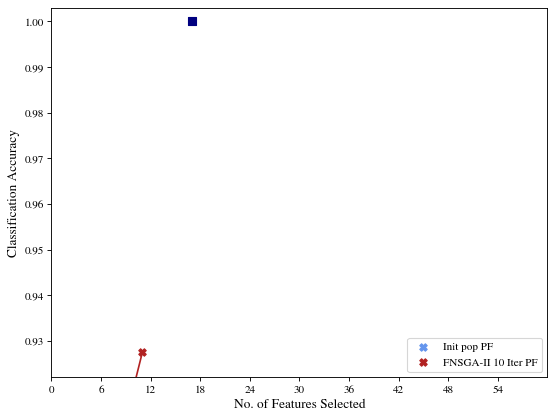

In [59]:
# One loop of outer loop (one value of i) is a RUN
# One loop of inner loop (one value of j) is an ITERATION
scores_paramsets = np.zeros((search_space.shape[0],1))
best_fronts_all_runs = []

for rep in range(5):
    init_pop = make_initial_pop(pop_size)
    init_pop_eval = evaluation(init_pop)
    init_fronts, init_fronts_indices = get_all_fronts(init_pop_eval, init_pop)

    for i in range(search_space.shape[0]):
        
        print(f"Population {rep}, Param Set {i}")
        
        config_params_change(config, search_space, i)
        
        param_set = (config["lambda_param"],config["tournament_param"],config["cross_k_param"],config["num_mutation_sites"],config["elitism_param"])
        
        print(f"Set at current iter is {param_set} in format (lam,tourn,cross,mut,elit)")
        
        localsearch_accepted = []

        polygon_selection = 0

        # For each new graph, store the best fronts in this array, for plotting
        fronts_all_iter = []
        fronts_all_iter.append(init_fronts[0])

        # Keep running array of arrays of all populations (for looping)
        every_iter_pop = []

        every_iter_pop.append(init_pop)

        # Do this many iterations of NSGA-II per graph
        for j in range(num_iter):

            iters_remaining = num_iter - (j+1)
            # Use PS for user set amount of last iter 
            if (iters_remaining <= polyselect_last_n):

                polyselect_param = iters_remaining/1000
                polygon_selection = 1

            NSGA2_create_next_generation(every_iter_pop[j], config)

        # Include the best Local Search evaluations in calculating the best front for the whole run
        if polygon_selection == 1:

            if len(localsearch_accepted) > 1:

                fronts_all_iter.append(best_PF(localsearch_accepted))

        # Get the non-dominated solution set for this run, store in array
        non_dom_this_run = best_PF(fronts_all_iter)
        
        best_fronts_all_runs.append(non_dom_this_run)

        # Score this parameter set, takes two fronts as arguments
        scores_paramsets[i] += get_run_score(init_fronts[0][:,:2], non_dom_this_run[:,:2])

# Average scores across all test runs
scores_paramsets = scores_paramsets/(rep+1)
save_numpy_array_as_csv(scores_paramsets, f"scores_50_sonar.csv")
    
# Plot best out of all parameter sets
non_dom_all_runs = best_PF(best_fronts_all_runs)
plot_PF(non_dom_all_runs, f'{data_set}_{num_iter}', show_or_save=1, lims=True)    

In [149]:
save_numpy_array_as_csv(non_dom_this_run, f'Graphs/{data_set}_{num_iter}.csv')

Array successfully saved as CSV file.


## Param Testing Results

Search has found the optimal parameters: 
 Lambda = 0.33333333333333337 
 Tourn = 1.0 
 LS = 4.0 
 Mut = 3.0 
 Elitism = 1.0


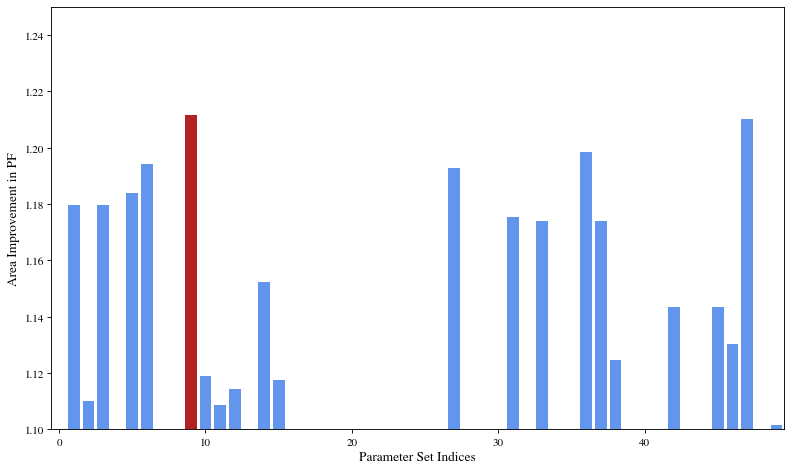

<Figure size 640x80 with 0 Axes>

In [65]:
scores_paramsets = genfromtxt('scores_50_sonar.csv', delimiter=',')

# Find the index of the parameter set with the maximum score
max_score_index = np.argmax(scores_paramsets)

# Create a color array for the bars, where all bars are "cornflowerblue" except the one with the maximum score
colors = ['cornflowerblue'] * len(scores_paramsets)
colors[max_score_index] = 'firebrick'

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(scores_paramsets)), scores_paramsets, color=colors)

# Set axis labels and title
plt.xlabel('Parameter Set Indices')
plt.ylabel('Area Improvement in PF')

plt.xlim(-0.52,49.52)

plt.ylim(1.1,1.25)

# Show the plot
plt.tight_layout()
plt.savefig(f"paramsetscores_ll_sonar.pdf", bbox_inches='tight', format="pdf", dpi=1200)
plt.figure().set_figheight(1)

best = search_space[max_score_index]

print(f"Search has found the optimal parameters: \n Lambda = {best[0]} \n Tourn = {best[1]} \n LS = {best[2]} \n Mut = {best[3]} \n Elitism = {best[4]}")

plt.show()

In [92]:
# Get averages for the best paramsets - above a certain threshold

score_thresh = 1.12

good_sets_index = np.where(scores_paramsets > score_thresh)[0]

good_sets = search_space[good_sets_index]

averages = np.mean(good_sets,axis=0)

param_names = ['lambda', 'tournament', 'crossover k', 'mutation', 'elitism']

print(f"In the top {good_sets.shape[0]} best performing parameter sets")

for i, avg in enumerate(averages):
    
    print(f"Parameter {param_names[i]} has an average of {avg}")

In the top 16 best performing parameter sets
Parameter lambda has an average of 0.5833333333333333
Parameter tournament has an average of 0.78125
Parameter crossover k has an average of 2.375
Parameter mutation has an average of 2.375
Parameter elitism has an average of 0.625


## For looking at results

In [ ]:
# Change index to the front of the graph you want to look at
front = non_dom_this_run
df = front_scores(front[:5], sortby = 'Recall')
display(df)

In [ ]:
# Use row index above to get the features that point trained on
get_names(front[4])

In [ ]:
latex_table = df.to_latex(index=False)
print(latex_table)

### Input a chromosome, get its scores

In [ ]:
chrom = np.asarray([1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1])
chrom_scores(chrom, sortby=scoring_metric)

# -------------------------   Testing/Development Area   -------------------------

In [ ]:
# Saving a population 
np.savetxt("diverse_recall_45feats.csv", diverse_pop, delimiter=",")

## PS Visualiser Functions

In [179]:
def display_polygons(fronts, neigh_ev_before, neigh_ev_after, polyselect_param, plot_polys, show_or_save):
    
    if len(fronts[0]) > 1:
        front = fronts[0]
        
    else:
        front = fronts[1]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    if plot_polys:
    
        polygon, poly_patch = make_polygons(front[:,:2], polyselect_param)
            
        ax.add_patch(poly_patch)
        
#     plt.xlim(min(front[:,0])-0.008, max(front[:,0])+0.008)
#     plt.ylim(0, max(front[:,1])+0.05)

#     plt.xlim(set_xlim[0],set_xlim[1])
#     plt.ylim(set_ylim[0],set_ylim[1])
                 
    if scoring_metric == 'Mixed':
        plt.xlabel('Avg. MC, Recall and F1 Scores')
        
    else:
        plt.xlabel(scoring_metric)
    
    plt.ylabel("Normalised Comp. Time")
    
                 
    plt.plot(front[:,0], front[:,1], c ='black', label="Pareto Front")
    plt.scatter(neigh_ev_before[:,0], neigh_ev_before[:,1], c ='firebrick', label="Rejected Solutions", marker="x", s=30)
    
    if neigh_ev_after.shape[0] != 0:
      
        plt.scatter(neigh_ev_after[:,0], neigh_ev_after[:,1], c = 'navy', label="Accepted Solutions", marker="s", s=30)
        
    plt.legend(loc='upper left')
    
    if show_or_save == 0:
        plt.savefig(f"Graphs/slice_{j}.pdf", format="pdf", dpi=1200, bbox_inches='tight')
        plt.clf()
        
    else:
        plt.show()

In [ ]:
polyselect_param = 0.003

pop = make_initial_pop(pop_size)
evaluated_pop = evaluation(pop)
fronts, fronts_indices = get_all_fronts(evaluated_pop, pop)
neigh_before =  neighbourhood_search(fronts, 4, front_points=6)
neigh_before_ev = evaluation(neigh_before)

neigh_after_ev, neigh_after = points_inside_area(fronts, neigh_before_ev)

display_polygons(fronts, neigh_before_ev, neigh_after_ev, polyselect_param, plot_polys=1, show_or_save=1)

## Polygon Selection Visualiser Functions

In [185]:
def plot_neighbourhood(fronts, data, crossed, mutated, show_or_save):
    
    front = fronts[0]
    
    plt.plot(front[:,0], front[:,1], c ='black', label="Pareto Front")

    # Plot neighbourhood
    plt.scatter(data[:,0], data[:,1], c ='firebrick', label='Local Search', s=30, marker="+")
    
    plt.scatter(crossed[:,0], crossed[:,1], c ='cornflowerblue', label='Crossed LS', s=30, marker="+")

    plt.scatter(mutated[:,0], mutated[:,1], c ='darkgreen', label='Mutated LS', s=30, marker="+")

#     plt.xlim(min(front[:,0])-0.008, max(front[:,0])+0.008)
#     plt.ylim(0.225, max(front[:,1])+0.05)
    
#     plt.xlim(set_xlim[0],set_xlim[1])
#     plt.ylim(set_ylim[0],set_ylim[1])

    if scoring_metric == 'Mixed':
        plt.xlabel('Avg. MC, Recall and F1 Scores')
        
    else:
        plt.xlabel(scoring_metric)
    
    plt.ylabel("Normalised Comp. Time")
    plt.legend(loc='upper left')
    
    if show_or_save == 0:
        plt.savefig(f"Graphs/slice_{j}.pdf", format="pdf", dpi=1200, bbox_inches='tight')
        plt.clf()
        
    else:
        plt.show()

In [ ]:
# Initialise seeded population
pop = make_initial_pop(pop_size)
evaluated_pop = evaluation(pop)
fronts, fronts_indices = get_all_fronts(evaluated_pop, pop)
neigh_before =  neighbourhood_search(fronts, 4, front_points=6)
neigh_ev_before = evaluation(neigh_before)

# neigh_ev_after, neigh_after = points_inside_area(fronts, neigh_ev_before)

crossed = crossover(1, cross_k_param, copy.deepcopy(neigh_after))
crossed_ev = evaluation(crossed)
mutated = mutation(crossed, 2)
mutated_ev = evaluation(mutated)
plot_neighbourhood(fronts, neigh_ev_before, crossed_ev, mutated_ev, show_or_save=1)

## Diverse population

In [85]:
def find_max_distance_points(evaluated_pop, num_chosen_points):
    
    '''
    In order to get a diverse population, pick points that are the furthest apart
    This function returns the chromosomes of those points, to act as input into the NSGA-II
    '''
    
    points = evaluated_pop[:,:2]
    
    chosen_indices = [random.randint(0, len(points) - 1)]
    distances = distance_matrix(points, points)
    max_distances = distances[chosen_indices[0]]

    for _ in range(num_chosen_points - 1):
        new_point_idx = np.argmax(max_distances)
        chosen_indices.append(new_point_idx)

        # Update max_distances with the minimum distance to the newly added point
        max_distances = np.minimum(max_distances, distances[new_point_idx])
        
    return evaluated_pop[chosen_indices]

In [ ]:
# # # Make small pop for comparison
pop = make_initial_pop(100)

pop_ev = evaluation(pop)

# Make big pop
big_pop = make_initial_pop(10000)

big_pop_ev = evaluation(big_pop)

# Get 100 points of big pop that are furthest apart
chosen_chromosomes = find_max_distance_points(big_pop_ev, 100)

diverse_pop = chosen_chromosomes[:,3:].astype(int)

# plt.scatter(pop_ev[:,0],pop_ev[:,1], c = 'firebrick', s=10, marker='x', label='Regular')

# plt.scatter(chosen_chromosomes[:,0],chosen_chromosomes[:,1], c = 'darkgreen', s=10, marker='x', label='Diverse')

# if scoring_metric == 'Mixed':
#     plt.xlabel('Avg. MC, Recall and F1 Scores')

# else:
#     plt.xlabel(scoring_metric)
    
# plt.ylabel("Normalised Comp. Time")

# # plt.vlines(x = score_all_X, ymin = 0, ymax = 1, color = 'purple', label=f"{scoring_metric} Full X", linestyle='--', linewidth=0.5)


# plt.legend(loc='upper left')
# plt.ylim(0.1,0.8)
# plt.xlim(0.1,0.75)

# plt.savefig(f"Graphs/diversityisourstrength_3.pdf", format="pdf", dpi=1200, bbox_inches='tight')

# plt.show()


### This function can be used for plotting the difference

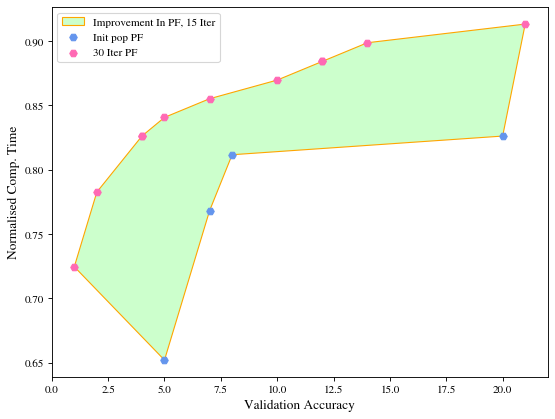

In [192]:
def create_polygon_from_piecewise_linear(points1, points2):
    """
    Create a polygon from two sets of points representing two separate piecewise linear functions.

    Parameters:
        points1 (numpy array): Points of the first piecewise linear function with shape (N, 2), where N is the number of points.
        points2 (numpy array): Points of the second piecewise linear function with shape (M, 2), where M is the number of points.

    Returns:
        matplotlib.patches.Polygon: A Matplotlib patch representing the polygon.
    """
    
    # Shapely draws vertices in the order you supply point tuples
    # So you have to supply the points in a specific order
    points_in_order = []
    
    # Reverse points list2
    points2 = points2[points2[:, 0].argsort()]
    
    # Combine both sets of points into a single array
    for point in points1:
        
        # Copies used because of paranoia
        points_in_order.append(copy.deepcopy([point[1],point[0]]))
            
    
    for point in points2:
        points_in_order.append(copy.deepcopy([point[1],point[0]]))
    
    polygon = Polygon(tuple(points_in_order))

    # Create a Matplotlib patch representing the polygon
    poly_patch = patches.Polygon(points_in_order, linewidth=1, edgecolor='orange', facecolor=(0, 1, 0, 0.2), label='Improvement In PF, 15 Iter')

    return polygon.area, poly_patch

# Example usage:
# Replace the following points with your actual data as numpy arrays
points1 = init_fronts[0][:,:2]
points2 = non_dom_this_run[:,:2]

polygon_area, polygon_patch = create_polygon_from_piecewise_linear(points1, points2)

# Plot the polygon using Matplotlib
fig, ax = plt.subplots()
ax.add_patch(polygon_patch)

plt.scatter(points1[:,1],points1[:,0], color = 'cornflowerblue', s=45, marker='H', label='Init pop PF')
plt.scatter(points2[:,1],points2[:,0], color = 'hotpink', s=45, marker='H', label='30 Iter PF')


plt.ylabel('Normalised Comp. Time')
plt.xlabel(scoring_metric)
plt.legend(loc='upper left')
# plt.xlim(set_xlim[0],set_xlim[1])
# plt.ylim(set_ylim[0],set_ylim[1])
plt.savefig(f"Graphs/run_scoring.pdf", format="pdf", dpi=1200, bbox_inches='tight')



In [193]:
polygon_area

1.695652173913043

## Tuning any given front

In [ ]:
# translates scores into strings that skopt understands
tuning_scoring_dict = {"Validation Accuracy": 'accuracy',
                  "Recall": 'recall',
                  "Precision": 'precision',
                  "F1 Score": 'f1',
                  "ROC AUC": 'roc_auc'}

In [ ]:
def tune_front(front, n_iter, cv):
    
    ''' 
    I: a front from get_all_fronts

    O: boosted 

    Only compatible with Gradient Boost

    Does not accept specificity as a score
    '''

    # Declare classifier 
    clf = GradientBoostingClassifier(random_state=42)

    # Currently unknown which parameters fuck up GradBoost
    # Declare parameter space for Gradient Boost
#     param_space = {
#         'n_estimators': Integer(10, 200),
#         'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
#         'max_depth': Integer(1, 10),
#         'min_samples_split': Integer(2, 20),
#         'min_samples_leaf': Integer(1, 10),
#         'subsample': Real(0.1, 1.0),
#         'loss': ['log_loss', 'exponential'],
#         'criterion': ['friedman_mse', 'squared_error']
#     }


    # Set up the Bayes search
    search = BayesSearchCV(clf, param_space, n_iter = n_iter, cv = cv, scoring = tuning_scoring_dict[scoring_metric],
                           refit = False, verbose = 0)
    
    front_pops = []
    
    # Get all pops of front
    for point in front:
        
        front_pops.append(point[3:].astype(int))
    
    # Evaluate objective values with new classifier
    return evaluation(np.asarray(front_pops), tuning=1, Bayes_search=search)

## See which partitions features are drawn from as optimal solutions

In [ ]:
def get_feature_prop(front):
    
    for el in front:
    
        chrom = el[3:].astype(int)

        partitions = [best_features, good_features, worst_features]

        feature_indices = np.where(chrom == 1)[0]

        for i, feat_set in enumerate(partitions):

            for feature in feature_indices:

                if feature in feat_set:

                    counts[i] += 1

## Vanilla NSGA-II

In [ ]:
def NSGA2_vanilla(pop, config):
    '''
    For a given population, generate its offspring population, including application of all operators
    '''
    
    # Load in parameters for this iter
    lambda_param = 1
    tournament_param = config["tournament_param"]
    crossover_param = config["crossover_param"]
    num_mutation_sites = config["num_mutation_sites"]
    cross_k_param = config["cross_k_param"]
    
    # Overwrite global var if any
    pop = pop
    
    # Get normalised obj values for population
    evaluated_pop = evaluation(pop)
        
    # Get fronts and the population index of each individual in each front
    fronts, fronts_indices = get_all_fronts(evaluated_pop, pop)
    crowding_metrics = get_crowding_distances(fronts)
    
    # Add the best front for this generation to a running list
    fronts_all_iter.append(fronts[0])
    
    # Sort every individual based on their domination rank and their crowding distance
    # The index of the fittest individual in this population is in index 0 
    sorted_nondom = nondominated_sort(fronts_indices, crowding_metrics, pop_size)
    
    # Sort by crowding metrics only
    sorted_crowding = sort_by_crowding_only(fronts_indices, crowding_metrics)
    
    # Define number of offspring left after tournament selection using the given parameters
    num_offspring = int(m.floor(tournament_param*pop.shape[0]))
    
    # Use tournament selection for choosing which surviving individuals get to crossover
    offspring = tournament_lambda(lambda_param, num_offspring, sorted_nondom, sorted_crowding, pop)

    # Do crossover on these offspring
    crossed_offspring = crossover(crossover_param, cross_k_param, offspring)

    # Do mutation on the crossed offspring
    next_generation = mutation(crossed_offspring, num_mutation_sites)
        
    # Want to keep pop_size consistent, generate new pop for the remainder needed for this
    if next_generation.shape[0]<pop_size: 
        
        until_popsize = int(pop_size - len(next_generation))
        remainder = make_initial_pop(until_popsize)
        next_generation = np.vstack((next_generation,remainder))
            
    every_iter_pop.append(next_generation)
    
    return None

In [ ]:
# One loop of outer loop (one value of i) is a RUN
# One loop of inner loop (one value of j) is an ITERATION

localsearch_accepted = []

polygon_selection = 0

# For each new graph, store the best fronts in this array, for plotting
fronts_all_iter = []
fronts_all_iter.append(init_fronts[0])

# Keep running array of arrays of all populations (for looping)
every_iter_pop = []

every_iter_pop.append(init_pop)

# Do this many iterations of NSGA-II per graph
for j in range(num_iter):
    
    iters_remaining = num_iter - (j+1)
    # Use PS for user set amount of last iter 
    if (iters_remaining <= polyselect_last_n):
        
        polyselect_param = iters_remaining/1000
        polygon_selection = 1

    NSGA2_vanilla(every_iter_pop[j], config)

# Include the best Local Search evaluations in calculating the best front for the whole run
if polygon_selection == 1:
    
    if len(localsearch_accepted) > 1:

        fronts_all_iter.append(best_PF(localsearch_accepted))

vanilla = best_PF(fronts_all_iter)

# plot_PF(non_dom_this_run, f'slice_{num_iter}', show_or_save=1)

# save_numpy_array_as_csv(non_dom_this_run, f"{num_iter}_iter_{scoring_metric}_{NSGA_model}.csv")